### Dataset

In this homework, we will use the Laptops price dataset from [Kaggle](https://www.kaggle.com/datasets/juanmerinobermejo/laptops-price-dataset).

Here's a wget-able [link](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv):

```bash
wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv
```

The goal of this homework is to create a regression model for predicting the prices (column `'Final Price'`).

In [28]:
# !wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv

### Preparing the dataset 

First, we'll normalize the names of the columns:

```python
df.columns = df.columns.str.lower().str.replace(' ', '_')
```

Now, instead of `'Final Price'`, we have `'final_price'`.

Next, use only the following columns:

* `'ram'`,
* `'storage'`,
* `'screen'`,
* `'final_price'`

In [29]:
import pandas as pd
import seaborn as sns
import numpy as np

In [30]:
df = pd.read_csv('laptops.csv')
df.columns = df.columns.str.lower().str.replace(' ', '_')
df = df[['ram', 'storage', 'screen', 'final_price']]
df.columns

Index(['ram', 'storage', 'screen', 'final_price'], dtype='object')

### EDA

* Look at the `final_price` variable. Does it have a long tail? 

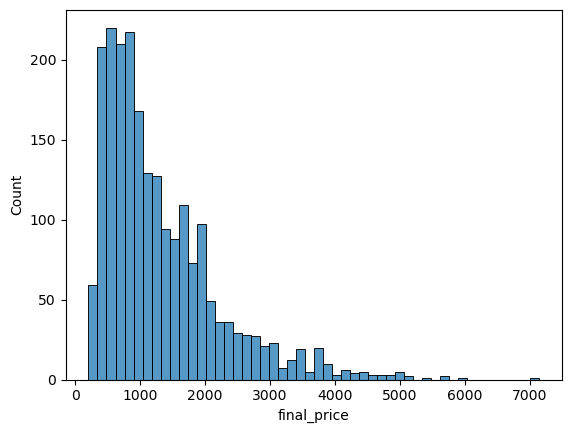

In [31]:
sns.histplot(df.final_price, bins=50);

### Question 1

There's one column with missing values. What is it?

* `'ram'`
* `'storage'`
* **`'screen'`**
* `'final_price'`

In [32]:
df.isnull().sum()

ram            0
storage        0
screen         4
final_price    0
dtype: int64

### Question 2

What's the median (50% percentile) for variable `'ram'`?

- 8
- **16**
- 24
- 32

In [33]:
df['ram'].median()

16.0

### Prepare and split the dataset

* Shuffle the dataset (the filtered one you created above), use seed `42`.
* Split your data in train/val/test sets, with 60%/20%/20% distribution.

Use the same code as in the lectures

In [34]:
n = len(df)

n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

In [35]:
df_train = df.iloc[:n_train]
df_val = df.iloc[n_train:n_train+n_val]
df_test = df.iloc[n_train+n_val:]

In [36]:
idx = np.arange(n)

In [37]:
np.random.seed(2)
np.random.shuffle(idx)

In [38]:
df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train+n_val]]
df_test = df.iloc[idx[n_train+n_val:]]

In [39]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [40]:
y_train = df_train.final_price.values
y_val = df_val.final_price.values
y_test = df_test.final_price.values

In [41]:
del df_train['final_price']
del df_val['final_price']
del df_test['final_price']



### Question 3

* We need to deal with missing values for the column from Q1.
* We have two options: fill it with 0 or with the mean of this variable.
* Try both options. For each, train a linear regression model without regularization using the code from the lessons.
* For computing the mean, use the training only!
* Use the validation dataset to evaluate the models and compare the RMSE of each option.
* Round the RMSE scores to 2 decimal digits using `round(score, 2)`
* Which option gives better RMSE?

Options:

- **With 0**
- With mean
- Both are equally good

In [42]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [43]:
def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [44]:
X_train_zeros = df_train.fillna(0).values
screen_mean = df_train['screen'].mean()
X_train_mean = df_train.fillna(screen_mean).values

In [45]:
w0_zeros, w_zeros = train_linear_regression(X_train_zeros, y_train)
w0_mean, w_mean = train_linear_regression(X_train_mean, y_train)

y_pred_zeros = w0_zeros + X_train_zeros.dot(w_zeros)
y_pred_mean = w0_mean + X_train_mean.dot(w_mean)

In [46]:
print(f"RMSE filling with zeros: {round(rmse(y_train, y_pred_zeros), 2)}")
print(f"RMSE filling with mean: {round(rmse(y_train, y_pred_mean), 2)}")

RMSE filling with zeros: 591.11
RMSE filling with mean: 591.74


### Question 4

* Now let's train a regularized linear regression.
* For this question, fill the NAs with 0. 
* Try different values of `r` from this list: `[0, 0.01, 0.1, 1, 5, 10, 100]`.
* Use RMSE to evaluate the model on the validation dataset.
* Round the RMSE scores to 2 decimal digits.
* Which `r` gives the best RMSE?

If there are multiple options, select the smallest `r`.

Options:

- 0
- 0.01
- 1
- **10**
- 100

In [47]:
X_val_zeros = df_val.fillna(0).values

In [48]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]


In [49]:
for r in [0, 0.01, 0.1, 1, 5, 10, 100]:
    w0, w = train_linear_regression_reg(X_train_zeros, y_train, r=r)

    y_pred = w0 + X_val_zeros.dot(w)
    score = rmse(y_val, y_pred)
    
    print(r, w0, round(score, 2))

0 649.4685454767654 588.96
0.01 648.8710192738281 588.95
0.1 643.5424086472517 588.93
1 594.7091802002469 588.75
5 444.78178978597686 588.34
10 338.2802680932726 588.17
100 64.21674428487401 588.21


### Question 5 

* We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
* Try different seed values: `[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]`.
* For each seed, do the train/validation/test split with 60%/20%/20% distribution.
* Fill the missing values with 0 and train a model without regularization.
* For each seed, evaluate the model on the validation dataset and collect the RMSE scores. 
* What's the standard deviation of all the scores? To compute the standard deviation, use `np.std`.
* Round the result to 3 decimal digits (`round(std, 3)`)

What's the value of std?

- 19.176
- **29.176**
- 39.176
- 49.176

> Note: Standard deviation shows how different the values are.
> If it's low, then all values are approximately the same.
> If it's high, the values are different. 
> If standard deviation of scores is low, then our model is *stable*.

In [50]:
def shuffle(df, seed):
    n = len(df)
    n_val = int(n * 0.2)
    n_test = int(n * 0.2)
    n_train = n - n_val - n_test

    idx = np.arange(n)

    np.random.seed(seed)
    np.random.shuffle(idx)
    
    df_train = df.iloc[idx[:n_train]]
    df_val = df.iloc[idx[n_train:n_train+n_val]]
    df_test = df.iloc[idx[n_train+n_val:]]

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    y_train = df_train.final_price.values
    y_val = df_val.final_price.values
    y_test = df_test.final_price.values

    del df_train['final_price']
    del df_val['final_price']
    del df_test['final_price']

    return df_train, df_val, df_test, y_train, y_val, y_test

In [51]:
def prepare(df):
    return df.fillna(0).values

In [52]:
rmse_scores = []
for seed in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    df_train, df_val, df_test, y_train, y_val, y_test = shuffle(df, seed)
    X_train = prepare(df_train)
    X_val = prepare(df_val)

    w0, w = train_linear_regression(X_train, y_train)
    y_pred = w0 + X_val.dot(w)

    rmse_scores.append(rmse(y_val, y_pred))


In [53]:
round(np.std(rmse_scores), 3)

np.float64(29.176)

### Question 6

* Split the dataset like previously, use seed 9.
* Combine train and validation datasets.
* Fill the missing values with 0 and train a model with `r=0.001`. 
* What's the RMSE on the test dataset?

Options:

- 598.60
- **608.60**
- 618.60
- 628.60

In [54]:
df_train, df_val, df_test, y_train, y_val, y_test = shuffle(df, 9)
df_train = pd.concat([df_train, df_val])
y_train = np.concatenate((y_train, y_val))

X_train = prepare(df_train)
X_test = prepare(df_test)

w0, w = train_linear_regression_reg(X_train, y_train, 0.001)
y_pred = w0 + X_test @ w

print(rmse(y_test, y_pred))


608.6099822049564
